# Deep Convloutional GAN (DCGAN)

- Referecnce : https://github.com/eriklindernoren/PyTorch-GAN

In [47]:
import argparse
import os
import numpy as np
import math
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

In [48]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Use MNIST Dataset & DataLoader

In [49]:
bs =128

dataset = datasets.MNIST("./mnist", train=True, download=True,
                         transform=transforms.Compose([transforms.Resize(32), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True, drop_last=True)

torch.Size([128, 1, 32, 32]) tensor([3, 1, 1, 3, 8, 3, 6, 6, 3, 6, 1, 5, 7, 8, 7, 5, 2, 8, 9, 8, 1, 2, 7, 5,
        3, 9, 4, 0, 0, 7, 7, 7, 4, 1, 3, 8, 8, 9, 4, 6, 4, 2, 2, 1, 4, 5, 1, 6,
        1, 8, 8, 2, 5, 6, 0, 7, 0, 6, 6, 3, 9, 3, 2, 1, 1, 3, 3, 4, 1, 8, 3, 8,
        7, 0, 3, 8, 0, 7, 7, 0, 6, 8, 7, 0, 6, 8, 2, 3, 4, 4, 0, 8, 5, 5, 6, 2,
        2, 6, 9, 9, 4, 0, 9, 0, 9, 6, 6, 4, 4, 3, 0, 1, 5, 3, 0, 1, 9, 1, 8, 2,
        4, 1, 8, 9, 8, 5, 4, 9])


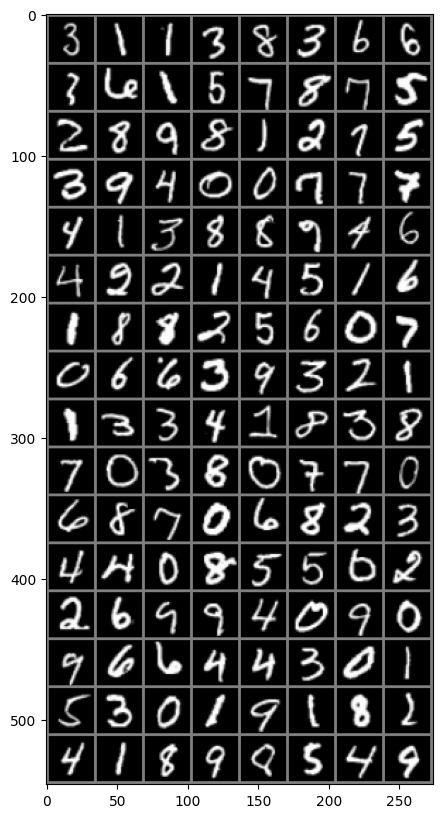

In [50]:
batch = next(iter(dataloader))
len(batch)
print(batch[0].shape, batch[1])

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.figure(figsize=(20,10))
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

imshow(torchvision.utils.make_grid(batch[0]))

## Define Generator & Discriminator
### Generator architecture
input random vector: 100 dim
* Linear: out_features 128 * 8 * 8
* BatchNorm2d
* Upsample: scale_factor 2
* Conv2d: out_channel: 128, kernel size 3, stride 1, padding 1
* BatchNorm2d
* LeakyReLU: 0.2
* Upsample: scale_factor 2
* Conv2d: out_channel: 64, kernel size 3, stride 1, padding 1
* BatchNorm
* LeakyReLU: 0.2
* Conv2d: out_channel: 1, kernel size 3, stride 1, padding 1
* Tanh

In [51]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        #### Implement Here ####
        self.fc1 = nn.Linear(100, 128*8*8)
        self.bn1 = nn.BatchNorm2d(128)
        self.up = nn.Upsample(scale_factor=2)
        self.act = nn.LeakyReLU(0.2)
        self.conv1 = nn.Conv2d(128, 128, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128, 64, 3, 1, 1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 1, 3, 1, 1)
        self.last_act = nn.Tanh()

    def forward(self, z):
        z = self.fc1(z)
        img = z.view(-1, 128, 8, 8)
        img = self.bn1(img)
        img = self.up(img)
        img = self.conv1(img)
        img = self.bn2(img)
        img = self.act(img)


        img = self.up(img)
        img = self.conv2(img)
        img = self.bn3(img)
        img = self.act(img)

        img = self.conv3(img)
        img = self.last_act(img)

        return img


### Discriminator architecture
input: [1 , 32 , 32] image
* Conv2d: out_channel: 16, kernel size 3, stride 2, padding 1
* LeakyReLU: 0.2
* Dropout: 0.25
* Conv2d: out_channel: 32, kernel size 3, stride 2, padding 1
* LeakyReLU: 0.2
* Dropout: 0.25
* BatchNorm2d
* Conv2d: out_channel: 64, kernel size 3, stride 2, padding 1
* LeakyReLU: 0.2
* Dropout: 0.25
* BatchNorm2d
* Conv2d: out_channel: 128, kernel size 3, stride 2, padding 1
* LeakyReLU: 0.2
* Dropout: 0.25
* BatchNorm2d
* Linear: out_features 1
* Sigmoid

In [52]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        #### Implement Here ####
        self.block1 = self.make_block(1, 16, False)
        self.block2 = self.make_block(16, 32)
        self.block3 = self.make_block(32, 64)
        self.block4 = self.make_block(64, 128)
        self.fc = nn.Linear(512, 1)
        self.last_act = nn.Sigmoid()


    def make_block(self, in_channel, out_channel, bn= True):
        #### Implement Here ####
        layers = [
            nn.Conv2d(in_channel, out_channel, 3, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25),
        ]
        if bn:
            layers.append(nn.BatchNorm2d(out_channel))

        return nn.Sequential(*layers)


    def forward(self, img):# [1, 32, 32]
        #### Implement Here ####
        img = self.block1(img)
        img = self.block2(img)
        img = self.block3(img)
        img = self.block4(img)
        x = img.view(img.size(0), -1)
        x = self.last_act(self.fc(x))

        return x


In [53]:
# Initialize generator and discriminator
G = Generator()
D = Discriminator()

In [54]:
from torchsummary import summary
summary(G, device = 'cpu', batch_size = -1, input_size = (100,))
summary(D, device = 'cpu', batch_size = -1, input_size = (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 8192]         827,392
       BatchNorm2d-2            [-1, 128, 8, 8]             256
          Upsample-3          [-1, 128, 16, 16]               0
            Conv2d-4          [-1, 128, 16, 16]         147,584
       BatchNorm2d-5          [-1, 128, 16, 16]             256
         LeakyReLU-6          [-1, 128, 16, 16]               0
          Upsample-7          [-1, 128, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          73,792
       BatchNorm2d-9           [-1, 64, 32, 32]             128
        LeakyReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11            [-1, 1, 32, 32]             577
             Tanh-12            [-1, 1, 32, 32]               0
Total params: 1,049,985
Trainable params: 1,049,985
Non-trainable params: 0
---------------------------

## Weight Initialization

In [55]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1: # Conv2d layer weights init
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1: # BatchNorm2d layer weights init
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


# weight initialize
G.apply(weights_init_normal)
D.apply(weights_init_normal)

Discriminator(
  (block1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.25, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.25, inplace=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.25, inplace=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.25, inplace=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats

## Define loss & Optimizer & model

* loss : BCELoss
* optimizer (for both G, D) : Adam with {lr=0.0002, betas=(0.5, 0.9999)}

In [56]:
#### Implement Here ####
# Loss function# Loss function
criterion = torch.nn.BCELoss()

optimizer_G = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.9999))
optimizer_D = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.9999))

## Start Training

In [57]:
G, D = G.to(device), D.to(device)
os.makedirs("./dcgan_images", exist_ok=True)
epochs = 25

[Epoch 0/25] [Batch 0/468] [D loss: 0.745647] [G loss: 0.733043]


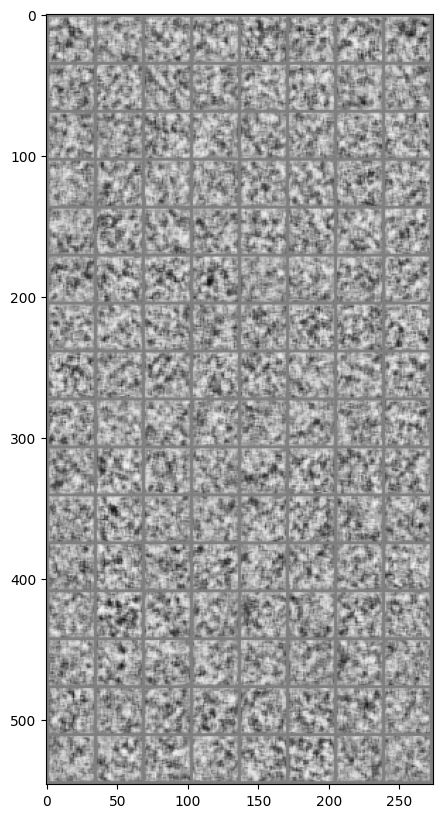

[Epoch 0/25] [Batch 100/468] [D loss: 0.642429] [G loss: 0.896389]
[Epoch 0/25] [Batch 200/468] [D loss: 0.719394] [G loss: 0.779905]
[Epoch 0/25] [Batch 300/468] [D loss: 0.711217] [G loss: 0.752694]
[Epoch 0/25] [Batch 400/468] [D loss: 0.677965] [G loss: 0.686203]
[Epoch 1/25] [Batch 32/468] [D loss: 0.677398] [G loss: 0.741058]
[Epoch 1/25] [Batch 132/468] [D loss: 0.627185] [G loss: 0.649414]
[Epoch 1/25] [Batch 232/468] [D loss: 0.566276] [G loss: 1.103365]
[Epoch 1/25] [Batch 332/468] [D loss: 0.635677] [G loss: 1.208565]
[Epoch 1/25] [Batch 432/468] [D loss: 0.603517] [G loss: 0.944538]
[Epoch 2/25] [Batch 64/468] [D loss: 0.636617] [G loss: 0.701258]
[Epoch 2/25] [Batch 164/468] [D loss: 0.518571] [G loss: 1.446858]
[Epoch 2/25] [Batch 264/468] [D loss: 0.467148] [G loss: 1.252476]
[Epoch 2/25] [Batch 364/468] [D loss: 0.478153] [G loss: 1.073778]
[Epoch 2/25] [Batch 464/468] [D loss: 0.521620] [G loss: 0.905794]
[Epoch 3/25] [Batch 96/468] [D loss: 0.502185] [G loss: 0.846846

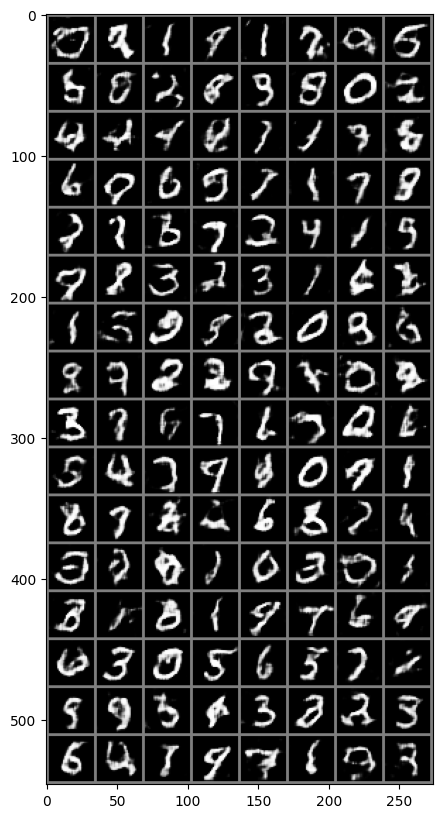

[Epoch 4/25] [Batch 228/468] [D loss: 0.732117] [G loss: 0.324874]
[Epoch 4/25] [Batch 328/468] [D loss: 0.362275] [G loss: 1.661572]
[Epoch 4/25] [Batch 428/468] [D loss: 0.418929] [G loss: 1.238736]
[Epoch 5/25] [Batch 60/468] [D loss: 0.273644] [G loss: 1.415789]
[Epoch 5/25] [Batch 160/468] [D loss: 0.360413] [G loss: 1.578697]
[Epoch 5/25] [Batch 260/468] [D loss: 0.372139] [G loss: 3.204347]
[Epoch 5/25] [Batch 360/468] [D loss: 0.432185] [G loss: 0.936353]
[Epoch 5/25] [Batch 460/468] [D loss: 0.328533] [G loss: 0.795787]
[Epoch 6/25] [Batch 92/468] [D loss: 0.318122] [G loss: 1.727945]
[Epoch 6/25] [Batch 192/468] [D loss: 0.267967] [G loss: 1.741299]
[Epoch 6/25] [Batch 292/468] [D loss: 0.390087] [G loss: 0.904937]
[Epoch 6/25] [Batch 392/468] [D loss: 0.170544] [G loss: 2.302483]
[Epoch 7/25] [Batch 24/468] [D loss: 0.508162] [G loss: 3.550582]
[Epoch 7/25] [Batch 124/468] [D loss: 0.250719] [G loss: 2.216958]
[Epoch 7/25] [Batch 224/468] [D loss: 0.270915] [G loss: 1.726428

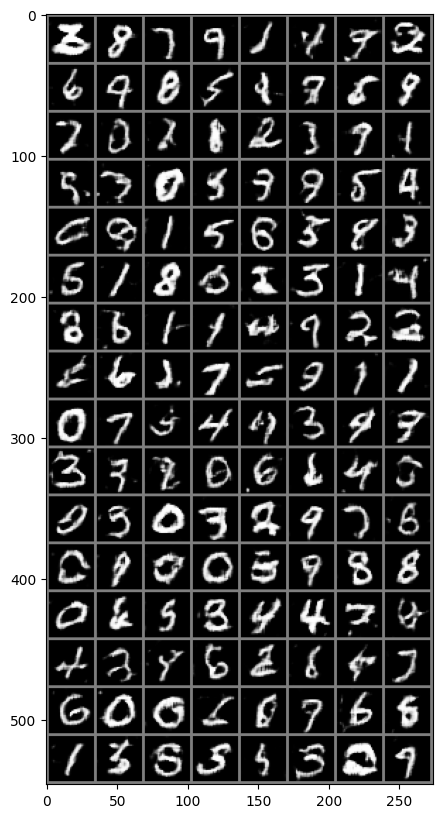

[Epoch 8/25] [Batch 356/468] [D loss: 0.471416] [G loss: 3.322979]
[Epoch 8/25] [Batch 456/468] [D loss: 0.298194] [G loss: 0.826054]
[Epoch 9/25] [Batch 88/468] [D loss: 0.179695] [G loss: 1.640962]
[Epoch 9/25] [Batch 188/468] [D loss: 0.290715] [G loss: 1.463853]
[Epoch 9/25] [Batch 288/468] [D loss: 0.285646] [G loss: 3.331010]
[Epoch 9/25] [Batch 388/468] [D loss: 0.199874] [G loss: 2.424790]
[Epoch 10/25] [Batch 20/468] [D loss: 0.151777] [G loss: 1.493645]
[Epoch 10/25] [Batch 120/468] [D loss: 0.342001] [G loss: 2.864248]
[Epoch 10/25] [Batch 220/468] [D loss: 0.168355] [G loss: 2.821416]
[Epoch 10/25] [Batch 320/468] [D loss: 0.508749] [G loss: 0.709313]
[Epoch 10/25] [Batch 420/468] [D loss: 0.077389] [G loss: 3.215534]
[Epoch 11/25] [Batch 52/468] [D loss: 0.122972] [G loss: 2.296601]
[Epoch 11/25] [Batch 152/468] [D loss: 0.403734] [G loss: 0.703936]
[Epoch 11/25] [Batch 252/468] [D loss: 0.257106] [G loss: 1.841362]
[Epoch 11/25] [Batch 352/468] [D loss: 0.098175] [G loss:

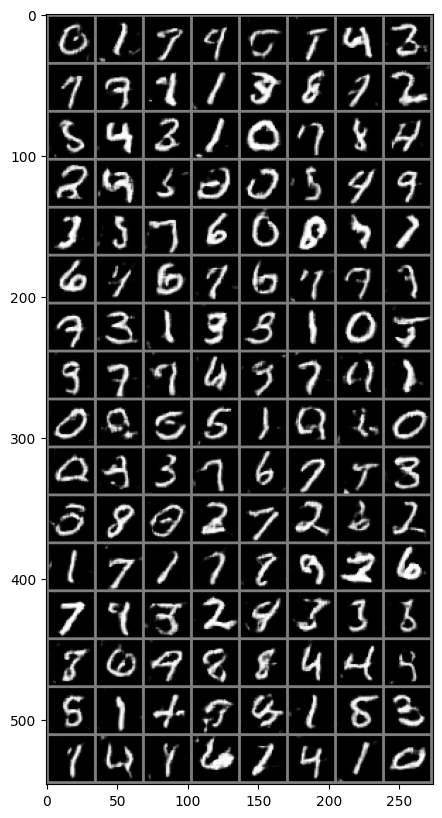

[Epoch 13/25] [Batch 16/468] [D loss: 0.186531] [G loss: 2.567068]
[Epoch 13/25] [Batch 116/468] [D loss: 0.305862] [G loss: 4.236010]
[Epoch 13/25] [Batch 216/468] [D loss: 0.178307] [G loss: 2.829202]
[Epoch 13/25] [Batch 316/468] [D loss: 0.129745] [G loss: 3.727747]
[Epoch 13/25] [Batch 416/468] [D loss: 0.138494] [G loss: 3.903835]
[Epoch 14/25] [Batch 48/468] [D loss: 0.122566] [G loss: 1.256204]
[Epoch 14/25] [Batch 148/468] [D loss: 0.080619] [G loss: 4.268963]
[Epoch 14/25] [Batch 248/468] [D loss: 0.053626] [G loss: 2.817181]
[Epoch 14/25] [Batch 348/468] [D loss: 0.068132] [G loss: 4.469774]
[Epoch 14/25] [Batch 448/468] [D loss: 0.351940] [G loss: 1.126376]
[Epoch 15/25] [Batch 80/468] [D loss: 0.099277] [G loss: 2.054533]
[Epoch 15/25] [Batch 180/468] [D loss: 0.147586] [G loss: 3.332224]
[Epoch 15/25] [Batch 280/468] [D loss: 0.106115] [G loss: 1.830589]
[Epoch 15/25] [Batch 380/468] [D loss: 0.049564] [G loss: 3.770617]
[Epoch 16/25] [Batch 12/468] [D loss: 0.087550] [G 

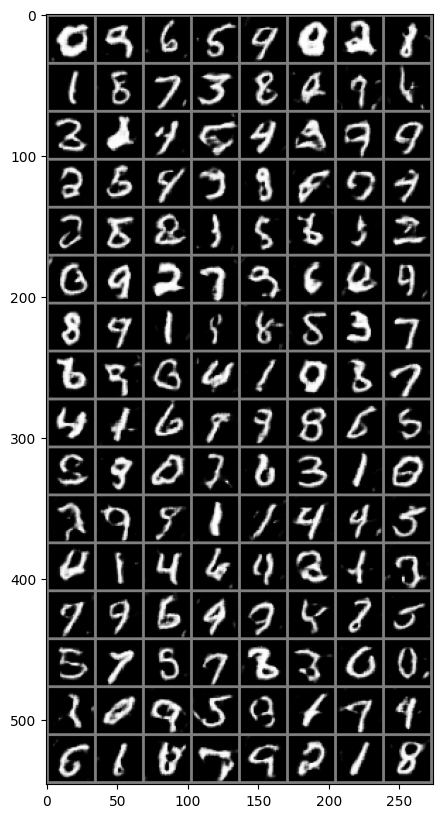

[Epoch 17/25] [Batch 144/468] [D loss: 0.175169] [G loss: 2.343823]
[Epoch 17/25] [Batch 244/468] [D loss: 0.051847] [G loss: 3.134884]
[Epoch 17/25] [Batch 344/468] [D loss: 0.150774] [G loss: 2.673108]
[Epoch 17/25] [Batch 444/468] [D loss: 0.124351] [G loss: 3.241501]
[Epoch 18/25] [Batch 76/468] [D loss: 0.063068] [G loss: 2.764557]
[Epoch 18/25] [Batch 176/468] [D loss: 0.135827] [G loss: 5.099617]
[Epoch 18/25] [Batch 276/468] [D loss: 0.059687] [G loss: 3.386731]
[Epoch 18/25] [Batch 376/468] [D loss: 0.047379] [G loss: 3.352248]
[Epoch 19/25] [Batch 8/468] [D loss: 0.075528] [G loss: 4.338367]
[Epoch 19/25] [Batch 108/468] [D loss: 0.047704] [G loss: 6.460117]
[Epoch 19/25] [Batch 208/468] [D loss: 0.123284] [G loss: 3.468701]
[Epoch 19/25] [Batch 308/468] [D loss: 0.116567] [G loss: 3.928609]
[Epoch 19/25] [Batch 408/468] [D loss: 0.074786] [G loss: 3.812516]
[Epoch 20/25] [Batch 40/468] [D loss: 0.031345] [G loss: 2.263744]
[Epoch 20/25] [Batch 140/468] [D loss: 0.069520] [G 

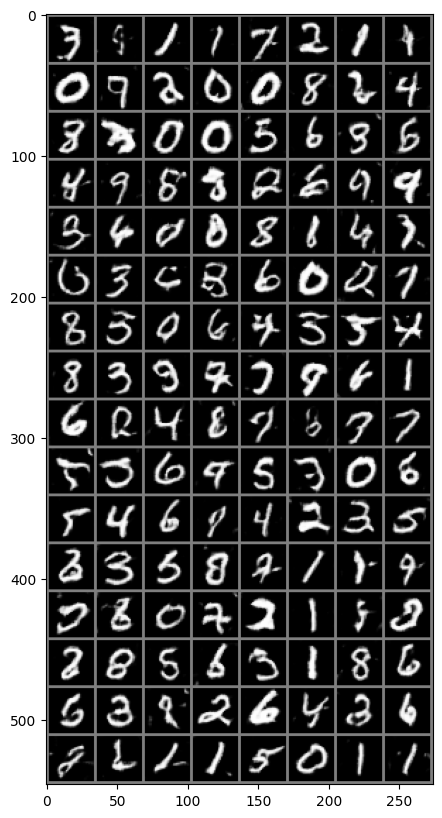

[Epoch 21/25] [Batch 272/468] [D loss: 0.040789] [G loss: 2.531276]
[Epoch 21/25] [Batch 372/468] [D loss: 0.075942] [G loss: 2.676685]
[Epoch 22/25] [Batch 4/468] [D loss: 0.075369] [G loss: 4.324035]
[Epoch 22/25] [Batch 104/468] [D loss: 0.054474] [G loss: 4.258856]
[Epoch 22/25] [Batch 204/468] [D loss: 0.059025] [G loss: 2.144852]
[Epoch 22/25] [Batch 304/468] [D loss: 0.103324] [G loss: 2.976899]
[Epoch 22/25] [Batch 404/468] [D loss: 0.231432] [G loss: 2.699303]
[Epoch 23/25] [Batch 36/468] [D loss: 0.153344] [G loss: 4.319867]
[Epoch 23/25] [Batch 136/468] [D loss: 0.023112] [G loss: 3.562261]
[Epoch 23/25] [Batch 236/468] [D loss: 0.029742] [G loss: 2.580390]
[Epoch 23/25] [Batch 336/468] [D loss: 0.061770] [G loss: 3.308928]
[Epoch 23/25] [Batch 436/468] [D loss: 0.075226] [G loss: 5.487281]
[Epoch 24/25] [Batch 68/468] [D loss: 0.158739] [G loss: 2.299648]
[Epoch 24/25] [Batch 168/468] [D loss: 0.078361] [G loss: 2.175135]
[Epoch 24/25] [Batch 268/468] [D loss: 0.070833] [G 

In [58]:
for epoch in range(epochs):
    for i, (real_imgs, _) in enumerate(dataloader):
        real_imgs = real_imgs.to(device)

        optimizer_G.zero_grad()

        z = torch.Tensor(np.random.normal(0, 1, (real_imgs.shape[0], 100))).to(device)
        gen_imgs = G(z)

        ones = torch.ones((gen_imgs.size(0), 1)).to(device)
        g_loss = criterion(D(gen_imgs), ones)

        g_loss.backward()
        optimizer_G.step()

        optimizer_D.zero_grad()

        ones = torch.ones((real_imgs.size(0), 1)).to(device)
        real_loss = criterion(D(real_imgs), ones)

        zeros = torch.zeros((gen_imgs.size(0), 1)).to(device)
        fake_loss = criterion(D(gen_imgs.detach()), zeros)

        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        batches_done = epoch * len(dataloader) + i

        if batches_done % 100 == 0:
            print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                  % (epoch, epochs, i, len(dataloader), d_loss.item(), g_loss.item()))

        if batches_done % 2000 == 0:
            save_image(gen_imgs.data, "dcgan_images/%06d.png" % batches_done, nrow=8, normalize=True)
            imshow(torchvision.utils.make_grid(gen_imgs.cpu()))


## Inference
- Check noise space

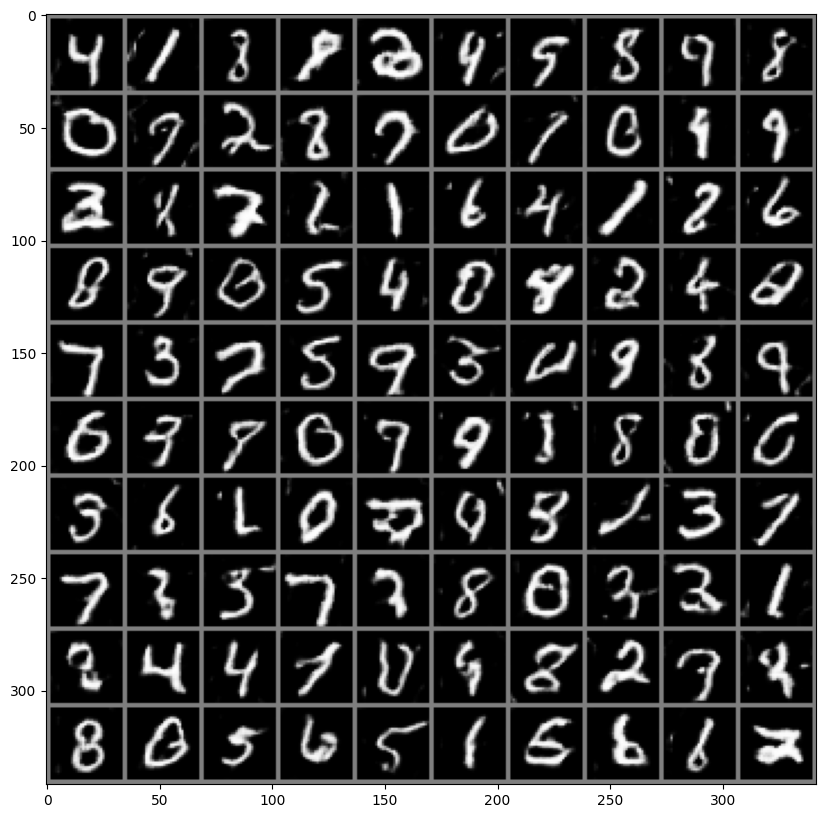

In [59]:
G.eval()
D.eval()

# 랜덤 노이즈(noise) 샘플링
z = torch.normal(mean=0, std=1, size=(100, 100)).to(device)

# 이미지 생성
gen_img = G(z)

imshow(torchvision.utils.make_grid(gen_img.detach().cpu(), nrow=10))

### Vector arithmetic
- Pick three samples of cluster and take mean

In [60]:
ones = (z[17].unsqueeze(0) + z[20].unsqueeze(0) + z[81].unsqueeze(0)) / 3
sevens = (z[0].unsqueeze(0) + z[10].unsqueeze(0) + z[12].unsqueeze(0)) / 3
nines = (z[22].unsqueeze(0) + z[20].unsqueeze(0) + z[97].unsqueeze(0)) / 3

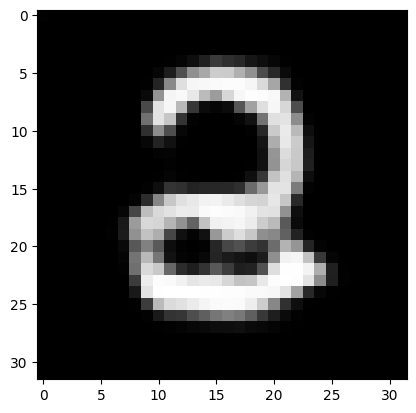

In [61]:
# ones
gen_img = G(ones).detach().cpu()
plt.imshow(gen_img.squeeze(0).permute(1, 2, 0).squeeze(2), cmap='gray')
plt.show()

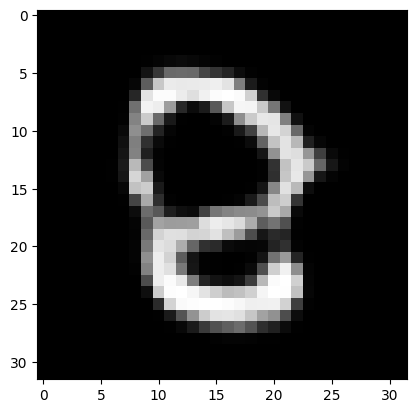

In [62]:
# sevens
gen_img = G(sevens).detach().cpu()
plt.imshow(gen_img.squeeze(0).permute(1, 2, 0).squeeze(2), cmap='gray')
plt.show()

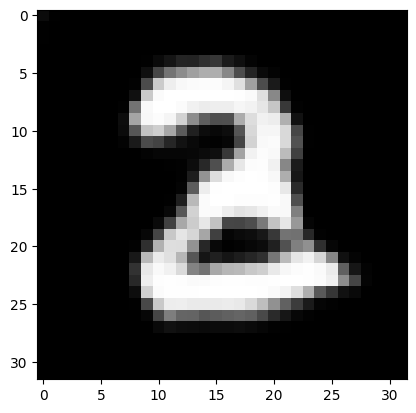

In [63]:
# twos
gen_img = G(nines).detach().cpu()
plt.imshow(gen_img.squeeze(0).permute(1, 2, 0).squeeze(2), cmap='gray')
plt.show()

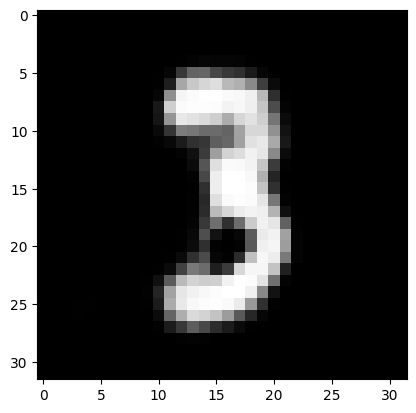

In [64]:
# vector_arithmetic
gen_vec = - ones + nines
gen_img = G(gen_vec).detach().cpu()
plt.imshow(gen_img.squeeze(0).permute(1, 2, 0).squeeze(2), cmap='gray')
plt.show()

### Noise Interpolation Visualize
- interpolate noise vector and visualize

torch.Size([10, 1, 32, 32])


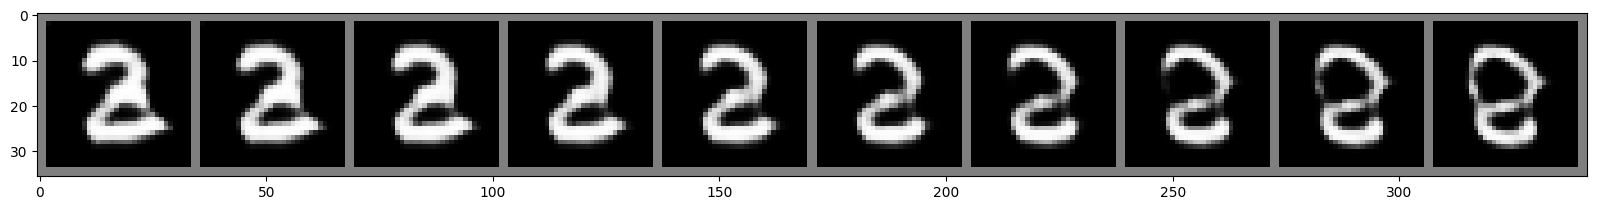

In [65]:
num_inter = 10
current = torch.Tensor(size=(num_inter, 100)).to(device)
for i in range(num_inter):
    current[i] = (sevens.squeeze(0) * (i / (num_inter-1)) + nines.squeeze(0) * (((num_inter-1) - i) / (num_inter-1)))

gen_img = G(current).detach().cpu()
print(gen_img.shape)
imshow(torchvision.utils.make_grid(gen_img, nrow=num_inter))